In [1]:
import pandas as pd
import torch

In [4]:
df = pd.DataFrame(
    {
"area": [120,180, 150, 210, 105],
"age": [5, 2, 1, 2, 1],
"price": [30, 90, 100, 180, 85]})

print(df.to_string(index=False))

 area  age  price
  120    5     30
  180    2     90
  150    1    100
  210    2    180
  105    1     85


In [5]:
import torch
import pandas as pd

data_tensor = torch.tensor(df.values, dtype=torch.float32)

min_vals = data_tensor.min(dim=0).values
max_vals = data_tensor.max(dim=0).values

# To prevent division by zero in case of constant columns, add a small epsilon
epsilon = 1e-8
normalized_tensor = (data_tensor - min_vals) / (max_vals - min_vals + epsilon)
normalized_df = pd.DataFrame(normalized_tensor.numpy(), columns=df.columns)

print("Original DataFrame:\n", df.to_string(index=False))
print("\nNormalized DataFrame (Min-Max Scaling):\n", normalized_df.to_string(index=False))

Original DataFrame:
  area  age  price
  120    5     30
  180    2     90
  150    1    100
  210    2    180
  105    1     85

Normalized DataFrame (Min-Max Scaling):
     area  age    price
0.142857 1.00 0.000000
0.714286 0.25 0.400000
0.428571 0.00 0.466667
1.000000 0.25 1.000000
0.000000 0.00 0.366667


In [9]:
df = normalized_df

In [10]:
X = torch.tensor(df[["area","age"]].values, dtype=torch.float32)
Y = torch.tensor(df[["price"]].values, dtype=torch.float32)

print(f"\nX:\n{X}\nY:\n{Y} ")


X:
tensor([[0.1429, 1.0000],
        [0.7143, 0.2500],
        [0.4286, 0.0000],
        [1.0000, 0.2500],
        [0.0000, 0.0000]])
Y:
tensor([[0.0000],
        [0.4000],
        [0.4667],
        [1.0000],
        [0.3667]]) 


In [11]:
# These 'W' (weights) and 'B' (biases) are initialized randomly and require gradients
# so they can be optimized during training.
W = torch.rand(size=(2, 1), requires_grad=True)
B = torch.rand(1, requires_grad=True)
print(f"W (Weights):\n{W}")
print(f"B (Bias):\n{B}")

W (Weights):
tensor([[0.3541],
        [0.5121]], requires_grad=True)
B (Bias):
tensor([0.2901], requires_grad=True)


In [13]:
def get_error_df(Y_true, Y_pred, error_tensor):
    """
    Creates a pandas DataFrame to display actual values, predictions, and errors.
    """
    results_df = pd.DataFrame({
        'Actual': Y_true.squeeze().numpy(),
        'Predicted': Y_pred.squeeze().detach().numpy(),
        'Squared Error': error_tensor.squeeze().detach().numpy()
    })
    return results_df

# Generate a prediction
pred = X @ W + B
error = (Y - pred) ** 2
loss = error.mean()

print("Error Details:\n", get_error_df(Y, pred, error))
print(f"\nLoss: {loss.item()}")

Error Details:
      Actual  Predicted  Squared Error
0  0.000000   0.852776       0.727227
1  0.400000   0.671073       0.073481
2  0.466667   0.441869       0.000615
3  1.000000   0.772255       0.051868
4  0.366667   0.290096       0.005863

Loss: 0.17181062698364258


Reducing Loss to with gradient descent

In [14]:
loss.backward()
dW = W.grad
dB = B.grad

print(f"W (Weights) gradients:\n{dW}")
print(f"B (Bias) gradients:\n{dB}")

W (Weights) gradients:
tensor([[0.0308],
        [0.3454]])
B (Bias) gradients:
tensor([0.3179])


In [15]:
lr = 0.01  # Learning rate

with torch.no_grad():
    W -= lr * dW  # Update W with Gradient descent
    B -= lr * dB  # Update B with Gradient descent

print(f"Updated W (Weights):\n{W}")
print(f"Updated B (Bias):\n{B}")

Updated W (Weights):
tensor([[0.3538],
        [0.5086]], requires_grad=True)
Updated B (Bias):
tensor([0.2869], requires_grad=True)


In [16]:
pred = X @ W+ B
new_loss = ((Y - pred) ** 2).mean()

print(f"Old Loss: {loss.item()}")
print(f"New Loss: {new_loss.item()}")

Old Loss: 0.17181062698364258
New Loss: 0.16961778700351715


In [18]:
new_loss.backward()
dW = W.grad
dB = B.grad

print(f"W (Weights) gradients:\n{dW}")
print(f"B (Bias) gradients:\n{dB}")

W (Weights) gradients:
tensor([[0.0578],
        [0.6874]])
B (Bias) gradients:
tensor([0.6271])


In [19]:
lr = 0.02  # Learning rate

with torch.no_grad():
    W -= lr * dW  # Update W with Gradient descent
    B -= lr * dB  # Update B with Gradient descent

print(f"Updated W (Weights):\n{W}")
print(f"Updated B (Bias):\n{B}")

Updated W (Weights):
tensor([[0.3521],
        [0.4880]], requires_grad=True)
Updated B (Bias):
tensor([0.2680], requires_grad=True)


Pytorch Optimizer

In [20]:
import torch.optim as optim

# Re-initialize weights and bias for a fresh start with the optimizer
W = torch.rand(size=(2, 1), requires_grad=True)
B = torch.rand(1, requires_grad=True)

# Define the optimizer (SGD - Stochastic Gradient Descent)
optimizer = optim.SGD(params=[W, B], lr=0.1)

# Training loop
for step in range(101):
    # 1. Forward pass: compute prediction
    pred = X @ W + B

    # 2. Calculate loss (Mean Squared Error)
    loss = ((Y - pred) ** 2).mean()

    # 3. Backward pass: compute gradients
    loss.backward()

    # 4. Update parameters using optimizer
    optimizer.step()

    # 5. Zero the gradients for the next iteration
    optimizer.zero_grad()

    if step % 10 == 0:
        print(f"Step: {step}, Loss: {loss.item():.4f}")

Step: 0, Loss: 0.2153
Step: 10, Loss: 0.0514
Step: 20, Loss: 0.0369
Step: 30, Loss: 0.0293
Step: 40, Loss: 0.0253
Step: 50, Loss: 0.0232
Step: 60, Loss: 0.0220
Step: 70, Loss: 0.0214
Step: 80, Loss: 0.0211
Step: 90, Loss: 0.0209
Step: 100, Loss: 0.0208


In [21]:
# Make predictions with the optimized W and B
final_pred = X @ W + B

# Calculate the squared error and the final loss
final_error = (Y - final_pred) ** 2
final_loss = final_error.mean()

# Display the error details using the helper function
print("Final Error Details (after optimization):\n", get_error_df(Y, final_pred, final_error))
print(f"\nFinal Loss (after optimization): {final_loss.item():.4f}")

Final Error Details (after optimization):
      Actual  Predicted  Squared Error
0  0.000000   0.007836       0.000061
1  0.400000   0.621678       0.049141
2  0.466667   0.536363       0.004858
3  1.000000   0.795635       0.041765
4  0.366667   0.275428       0.008325

Final Loss (after optimization): 0.0208


In [22]:
original_df = pd.DataFrame(
    {
'area': [120,180, 150, 210, 105],
'age': [5, 2, 1, 2, 1],
'price': [30, 90, 100, 180, 85]})

original_price_min = original_df['price'].min()
original_price_max = original_df['price'].max()

print(f"Original DataFrame:\n{original_df.to_string(index=False)}")
print(f"\nOriginal price min: {original_price_min}")
print(f"Original price max: {original_price_max}")

Original DataFrame:
 area  age  price
  120    5     30
  180    2     90
  150    1    100
  210    2    180
  105    1     85

Original price min: 30
Original price max: 180


In [23]:
denormalized_Y = Y * (original_price_max - original_price_min) + original_price_min
denormalized_final_pred = final_pred * (original_price_max - original_price_min) + original_price_min

print(f"Denormalized Actual Prices (Y):\n{denormalized_Y.squeeze()}")
print(f"\nDenormalized Predicted Prices (final_pred):\n{denormalized_final_pred.squeeze()}")

Denormalized Actual Prices (Y):
tensor([ 30.,  90., 100., 180.,  85.])

Denormalized Predicted Prices (final_pred):
tensor([ 31.1754, 123.2516, 110.4545, 149.3452,  71.3141],
       grad_fn=<SqueezeBackward0>)


In [24]:
denormalized_error = (denormalized_Y - denormalized_final_pred) ** 2
denormalized_loss = denormalized_error.mean()

print(f"Denormalized Loss: {denormalized_loss.item():.4f}")

Denormalized Loss: 468.6737


In [26]:
results_df_denormalized = pd.DataFrame({
    'Original Actual Price': denormalized_Y.squeeze().detach().numpy(),
    'Denormalized Predicted Price': denormalized_final_pred.squeeze().detach().numpy(),
    'Denormalized Squared Error': denormalized_error.squeeze().detach().numpy()
})

print("Denormalized Results:\n", results_df_denormalized.to_string(index=False))

Denormalized Results:
  Original Actual Price  Denormalized Predicted Price  Denormalized Squared Error
                  30.0                     31.175415                    1.381600
                  90.0                    123.251625                 1105.670532
                 100.0                    110.454460                  109.295738
                 180.0                    149.345184                  939.717712
                  85.0                     71.314140                  187.302750


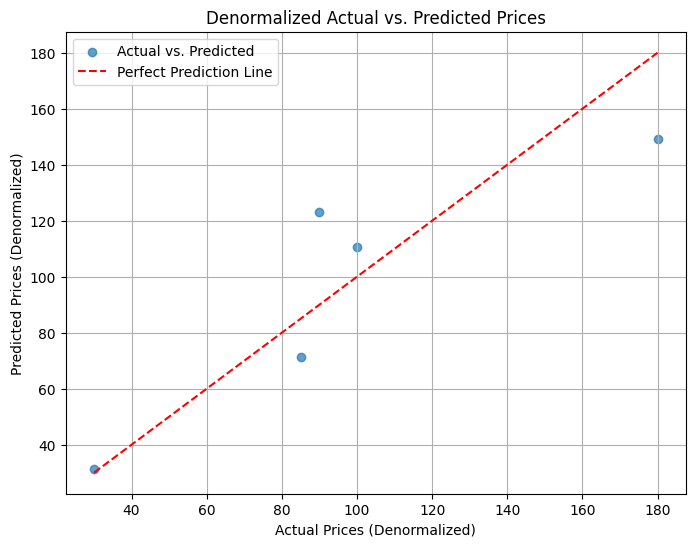

In [27]:
import matplotlib.pyplot as plt

# Convert tensors to numpy for plotting
actual_prices = denormalized_Y.squeeze().detach().numpy()
predicted_prices = denormalized_final_pred.squeeze().detach().numpy()

# Create the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(actual_prices, predicted_prices, label='Actual vs. Predicted', alpha=0.7)

# Add a line representing perfect predictions
min_val = min(actual_prices.min(), predicted_prices.min())
max_val = max(actual_prices.max(), predicted_prices.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Prediction Line')

# Set labels and title
plt.xlabel('Actual Prices (Denormalized)')
plt.ylabel('Predicted Prices (Denormalized)')
plt.title('Denormalized Actual vs. Predicted Prices')

# Add legend and grid
plt.legend()
plt.grid(True)
plt.show()